In [50]:
import pandas as pd 
import json
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from openai import OpenAI
import seaborn as sns
import matplotlib.pyplot as plt


Loading documents with IDs

In [2]:
#loading data
with open('documents-with-ids.json', 'r') as file:  # Replace 'data.json' with the path to your file
    data = json.load(file)

In [3]:
data[10]

{'body': '12 Jul 2022 byAngelica Lo Duca',
 'Title': 'Building a Data Science Team',
 'id': '024e0acf'}

Loading Ground Truth data

In [4]:
df_ground_truth = pd.read_csv('ground-truth-data.csv')
ground_truth = df_ground_truth.to_dict(orient='records')
ground_truth[10]

{'question': 'What is the main focus of machine learning engineers?',
 'title': 'Roles in a Data Team',
 'body': 'Machine learning engineers take whatever data scientists build and help them scale it up. They also ensure that the service is maintainable and that the team follows the best engineering practices. Their focus is more on engineering than on modeling. The skills ML engineers have are similar to that of data engineers: Additionally, ML engineers work closely with more “traditional” engineers, like backend engineers, frontend engineers, or mobile engineers, to ensure that the services from the data team are included in the final product. For our example, ML engineers work together with data scientists on productionizing the category suggestion services. They make sure it’s stable once it’s rolled out to all the users. They must also ensure that it’s maintainable and it’s possible to make changes to the service in the future. There’s another kind of engineer that can be pretty 

In [5]:
doc_idx = {d['id']: d for d in data}
doc_idx['024e0acf']['body']

'12 Jul 2022 byAngelica Lo Duca'

In [6]:
# merging the ground truth dict and data dict on 'id' to get the questions on the data dict
for i in data:
    for j in ground_truth:
        if j['document'] == i['id']:
            # Add the `question` key and value from dict1 to dict2
            i['question'] = j['question']

# Print the updated dict2
data[1]


{'body': 'A typical data team consists of the following roles: All these people work to create a data product. To explain the core responsibilities of each role, we will use a case scenario: Suppose we work at an online classifieds company. It’s a platform where users can go to sell things they don’t need (like OLX, where I work). If a user has an iPhone they want to sell — they go to this website, create a listing and sell their phone. On this platform, sellers sometimes have problems with identifying the correct category for the items they are selling. To help them, we want to build a service that suggests the best category. To sell their iPhone, the user creates a listing and the site needs to automatically understand that this iPhone has to go in the “mobile phones” category. Let’s start with the first role: product manager.',
 'Title': 'Roles in a Data Team',
 'id': '80c6bcf6'}

Indexing Data

In [9]:
es_client = Elasticsearch('http://localhost:9200') 

In [10]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "heading": {"type": "text"},
            "body": {"type": "text"},
            "question": {"type": "text"},
            "Title": {"type": "keyword"} ,
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 768,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "data-roles-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'data-roles-questions'})

Loading model embedding

In [11]:
model = SentenceTransformer("all-mpnet-base-v2")

/home/purity/.local/share/virtualenvs/llm-zoomcamp-18Y2mSdS/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/purity/.local/share/virtualenvs/llm-zoomcamp-18Y2mSdS/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [13]:
v = data[0]['question_text_vector']
v

array([ 5.70629872e-02,  5.37785189e-03,  4.84102499e-03,  5.20084053e-03,
       -4.34548929e-02, -5.61786816e-03,  7.75832385e-02,  8.30628630e-03,
       -1.60205755e-02,  2.05813553e-02,  4.17552963e-02,  4.03706059e-02,
        5.91600221e-03,  4.60194275e-02,  2.21639872e-02,  3.26464623e-02,
        4.81393151e-02,  6.73986375e-02, -4.75985669e-02, -2.03411235e-03,
       -3.89140323e-02,  2.10396256e-02, -3.76126431e-02, -6.36897403e-06,
        3.51941586e-02,  3.90307941e-02,  4.87847589e-02, -2.91396095e-03,
       -5.34133799e-02, -5.78989834e-02,  1.68280862e-02, -2.06187889e-02,
       -3.13282758e-02,  1.27918376e-02,  1.92767425e-06, -2.26725955e-02,
       -5.53324819e-02,  2.16679592e-02,  3.12046874e-02,  5.63912420e-03,
        1.72224138e-02, -3.89154591e-02, -9.77614801e-03,  5.90093853e-03,
       -4.52275351e-02, -6.13026954e-02,  3.54369101e-03,  4.31575067e-02,
       -2.42418423e-02,  7.17974529e-02, -1.27895772e-02,  2.02247072e-02,
        2.09246222e-02, -

In [14]:
v.shape

(768,)

In [12]:
# filtering out dictionaries without questions
new_data = []

for d in data:
    # Check if the required key is present
    if 'question' not in d:
        continue

    # If all conditions pass, add the dictionary to the filtered list
    new_data.append(d)

print(len(new_data))

17


In [13]:
for doc in tqdm(new_data):
    question = doc['question']
    text = doc['body']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


Retrieval

In [14]:
def elastic_search_knn(field, vector, title):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "Title": title
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["body", "question", "Title", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [19]:
def question_text_vector_knn(q):
    question = q['question']
    title = q['title']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, title)

In [20]:
question_text_vector_knn(dict(
    question='How can Iget a job as a Data Engineer?',
    title='Guidelines to Get a Data Engineer Job Against the Odds'
))

[{'question': "What is the author's biography?",
  'Title': 'Guidelines to Get a Data Engineer Job Against the Odds',
  'id': '59385f12',
  'body': '04 Jan 2023 byLuís Oliveira'}]

The RAG Flow

In [29]:
def build_prompt(query, search_results):
    prompt_template = """
You're a career assistant that helps people know more about data careers. Answer the QUESTION based on the CONTEXT from the knowledge base.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"title: {doc['Title']}\n, content: {doc['body']}\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [23]:
client = OpenAI(
    base_url='http://localhost:11434/v1/',
    api_key='ollama',
)

In [24]:
def llm(prompt):
    response = client.chat.completions.create(
        model='gemma:2b',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [27]:
def rag(query: dict):
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt)
    return answer

In [26]:
ground_truth[10]

{'question': 'What is the main focus of machine learning engineers?',
 'title': 'Roles in a Data Team',
 'body': 'Machine learning engineers take whatever data scientists build and help them scale it up. They also ensure that the service is maintainable and that the team follows the best engineering practices. Their focus is more on engineering than on modeling. The skills ML engineers have are similar to that of data engineers: Additionally, ML engineers work closely with more “traditional” engineers, like backend engineers, frontend engineers, or mobile engineers, to ensure that the services from the data team are included in the final product. For our example, ML engineers work together with data scientists on productionizing the category suggestion services. They make sure it’s stable once it’s rolled out to all the users. They must also ensure that it’s maintainable and it’s possible to make changes to the service in the future. There’s another kind of engineer that can be pretty 

In [30]:
rag(ground_truth[10])

'According to the context, the main focus of machine learning engineers is to help data scientists scale their data-driven applications. They ensure that the data-driven applications are efficient, stable, and maintainable.'

In [31]:
doc_idx['f10a49a7']['body']

'Machine learning engineers take whatever data scientists build and help them scale it up. They also ensure that the service is maintainable and that the team follows the best engineering practices. Their focus is more on engineering than on modeling. The skills ML engineers have are similar to that of data engineers: Additionally, ML engineers work closely with more “traditional” engineers, like backend engineers, frontend engineers, or mobile engineers, to ensure that the services from the data team are included in the final product. For our example, ML engineers work together with data scientists on productionizing the category suggestion services. They make sure it’s stable once it’s rolled out to all the users. They must also ensure that it’s maintainable and it’s possible to make changes to the service in the future. There’s another kind of engineer that can be pretty important in a data team — site reliability engineers.'

Cosine Similarity Metric

In [33]:
answer_orig = "Machine learning engineers take whatever data scientists build and help them scale it up. They also ensure that the service is maintainable and that the team follows the best engineering practices. Their focus is more on engineering than on modeling. The skills ML engineers have are similar to that of data engineers: Additionally, ML engineers work closely with more “traditional” engineers, like backend engineers, frontend engineers, or mobile engineers, to ensure that the services from the data team are included in the final product. For our example, ML engineers work together with data scientists on productionizing the category suggestion services. They make sure it’s stable once it’s rolled out to all the users. They must also ensure that it’s maintainable and it’s possible to make changes to the service in the future. There’s another kind of engineer that can be pretty important in a data team — site reliability engineers."
answer_llm = " According to the context, the main focus of machine learning engineers is to help data scientists scale their data-driven applications. They ensure that the data-driven applications are efficient, stable, and maintainable."



In [34]:
v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.7687918)

In [37]:
len(ground_truth)

85

In [39]:
ground_truth[10]

{'question': 'What is the main focus of machine learning engineers?',
 'title': 'Roles in a Data Team',
 'body': 'Machine learning engineers take whatever data scientists build and help them scale it up. They also ensure that the service is maintainable and that the team follows the best engineering practices. Their focus is more on engineering than on modeling. The skills ML engineers have are similar to that of data engineers: Additionally, ML engineers work closely with more “traditional” engineers, like backend engineers, frontend engineers, or mobile engineers, to ensure that the services from the data team are included in the final product. For our example, ML engineers work together with data scientists on productionizing the category suggestion services. They make sure it’s stable once it’s rolled out to all the users. They must also ensure that it’s maintainable and it’s possible to make changes to the service in the future. There’s another kind of engineer that can be pretty 

In [38]:
answers = {}

In [40]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['body']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'title': rec['title'],
    }

100%|██████████| 85/85 [29:58<00:00, 21.16s/it]


In [41]:
results = [None] * len(ground_truth)

for i, val in answers.items():
    results[i] = val.copy()
    results[i].update(ground_truth[i])

In [43]:
df_results = pd.DataFrame(results)
df_results.head(10)

,answer_llm,answer_orig,document,question,title,body
0,The purpose of the trip is not mentioned in th...,14 Dec 2020 byAlexey Grigorev,d2d8f692,What was the purpose of the trip?,Roles in a Data Team,14 Dec 2020 byAlexey Grigorev
1,"Sure, here are the specific details that were ...",14 Dec 2020 byAlexey Grigorev,d2d8f692,What specific details were included in the art...,Roles in a Data Team,14 Dec 2020 byAlexey Grigorev
2,The context does not provide any notable quote...,14 Dec 2020 byAlexey Grigorev,d2d8f692,Are there any notable quotes or anecdotes from...,Roles in a Data Team,14 Dec 2020 byAlexey Grigorev
3,The information about the result of the trip i...,14 Dec 2020 byAlexey Grigorev,d2d8f692,What was the result of the trip?,Roles in a Data Team,14 Dec 2020 byAlexey Grigorev
4,The context does not provide information about...,14 Dec 2020 byAlexey Grigorev,d2d8f692,What were the conclusions drawn from the outcome?,Roles in a Data Team,14 Dec 2020 byAlexey Grigorev
5,Sure. Here is the answer to your question:\n\n...,The roles of a data scientist and data analyst...,99ce651b,What is the difference between a data scientis...,Roles in a Data Team,The roles of a data scientist and data analyst...
6,A data scientist focuses more on creating mach...,The roles of a data scientist and data analyst...,99ce651b,How does a data scientist use data to create a...,Roles in a Data Team,The roles of a data scientist and data analyst...
7,A data scientist focuses more on creating mach...,The roles of a data scientist and data analyst...,99ce651b,What does a data scientist focus more on when ...,Roles in a Data Team,The roles of a data scientist and data analyst...
8,A data scientist's main focus is on creating m...,The roles of a data scientist and data analyst...,99ce651b,What is the main focus of a data scientist's job?,Roles in a Data Team,The roles of a data scientist and data analyst...
9,A data scientist focuses more on engineering t...,The roles of a data scientist and data analyst...,99ce651b,How does a data scientist's focus on engineeri...,Roles in a Data Team,The roles of a data scientist and data analyst...


In [45]:
results_gemma = df_results.to_dict(orient='records')
results_gemma[10]

{'answer_llm': 'The main focus of machine learning engineers is to help the data scientists build machine learning models that can be used to predict something.',
 'answer_orig': 'Machine learning engineers take whatever data scientists build and help them scale it up. They also ensure that the service is maintainable and that the team follows the best engineering practices. Their focus is more on engineering than on modeling. The skills ML engineers have are similar to that of data engineers: Additionally, ML engineers work closely with more “traditional” engineers, like backend engineers, frontend engineers, or mobile engineers, to ensure that the services from the data team are included in the final product. For our example, ML engineers work together with data scientists on productionizing the category suggestion services. They make sure it’s stable once it’s rolled out to all the users. They must also ensure that it’s maintainable and it’s possible to make changes to the service i

In [46]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [47]:
similarity = []

for record in tqdm(results_gemma):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 85/85 [00:23<00:00,  3.67it/s]


In [48]:
df_results['cosine'] = similarity
df_results['cosine'].describe()

count    85.000000
mean      0.568503
std       0.248405
min       0.008574
25%       0.474935
50%       0.621837
75%       0.735914
max       0.913466
Name: cosine, dtype: float64

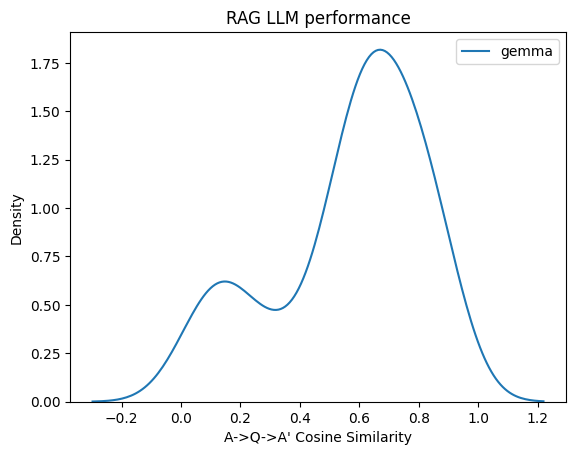

In [51]:
sns.kdeplot(df_results['cosine'], label='gemma')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()
plt.show()

LLM-as-a-judge

In [57]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [52]:
len(df_results)

85

In [53]:
df_sample = df_results.sample(n=40, random_state=1)

In [54]:
samples = df_sample.to_dict(orient='records')

In [55]:
record = samples[0]
record

{'answer_llm': 'According to the context, the skills and experience needed to assemble a strong product team include:\n\n* A clear vision for the product.\n* Individuals with the skills and experience necessary to bring that vision to fruition.\n* Strong communication skills and the ability to work effectively in a team environment.',
 'answer_orig': 'To build a strong product team, it is important to first understand what a product team is.A product team is responsible for the development and management of a company’s products.This includes everything from the initial idea and conception of the product, to its design, production, and eventual distribution. A strong product team is a team that is building a product that the customer wants. Strong means: In other words, a strong product team will have a clear understanding of the market they are targeting and will work together to ensure that the final product meets the needs of their target audience. In order to build a strong product 

In [58]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: To build a strong product team, it is important to first understand what a product team is.A product team is responsible for the development and management of a company’s products.This includes everything from the initial idea and conception of the product, to its design, production, and eventual distribution. A strong product team is a team that is building a product that the customer wants. Strong means: In other words, a strong product team will have a clear understanding of the market they are targeting and will work together to ensure that the final product meets the needs of their target audi

In [59]:
answer = llm(prompt)
answer

'{\n  "Relevance": "NON_RELEVANT",\n  "Explanation": "The generated answer provides some relevant information about the skills and experience needed to assemble a strong product team, but it lacks depth and fails to capture the essence of the original answer. The answer could be improved by providing a more comprehensive and accurate understanding of the topic."\n}'

In [60]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt)
    evaluations.append(evaluation)

100%|██████████| 40/40 [08:08<00:00, 12.22s/it]


In [62]:
evaluations[0]

'{\n  "Relevance": "NON_RELEVANT",\n  "Explanation": "The generated answer provides only relevant skills and experience needed to assemble a strong product team, but it lacks context and discussion about how each skill contributes to the team\'s success."\n}'

In [63]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    try:
        json_eval = json.loads(str_eval)
        json_evaluations.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")

Error decoding JSON at index 1: Extra data: line 7 column 1 (char 332)
Problematic string: {
  "Relevance": "NON_RELEVANT",
  "Explanation": "The passage suggests that a simple task, like a homework assignment, can help to assess a data scientist's skills and attention to detail. However, the passage does not provide any specific information about how a simple task can be used to assess these skills and abilities."
}


**Note:** The provided context does not contain any information about the relevancy or similarity of the generated answer compared to the original answer.
Error decoding JSON at index 3: Invalid control character at: line 3 column 99 (char 131)
Problematic string: {
  "Relevance": "NON_RELEVANT",
  "Explanation": "The generated answer does not provide any information about the relevance of the
    generated answer compared to the original answer."
}
Error decoding JSON at index 11: Expecting ',' delimiter: line 3 column 247 (char 279)
Problematic string: {
  "Relevance":

In [64]:
len(json_evaluations)

34

In [65]:
df_evaluations = pd.DataFrame(json_evaluations)

In [66]:
df_evaluations.Relevance.value_counts()

Relevance
NON_RELEVANT       33
PARTLY_RELEVANT     1
Name: count, dtype: int64

In [67]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
0,NON_RELEVANT,The generated answer provides only relevant sk...
1,NON_RELEVANT,The generated answer does not provide any rele...
2,NON_RELEVANT,The context does not provide any information a...
3,NON_RELEVANT,The generated answer provides no information a...
4,NON_RELEVANT,The generated answer does not provide any info...
5,NON_RELEVANT,The generated answer does not provide any info...
6,NON_RELEVANT,The generated answer does not provide any info...
7,NON_RELEVANT,The generated answer provides some basic infor...
8,NON_RELEVANT,The generated answer does not provide any exam...
9,NON_RELEVANT,The answer provides a definition of a data sci...


In [68]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What is the advantage of hiring specialists compared to generalists?
Generated Answer: The advantage of hiring specialists compared to generalists is that specialists will be able to bring a lot of knowledge to the table. Specialists should be able to work on specific tasks and solve a particular problem. Generalists should be able to work on a variety of tasks and roles.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluat

In [69]:
evaluation = llm(prompt)
print(evaluation)

{
  "Relevance": "NON_RELEVANT",
  "Explanation": "The generated answer is completely irrelevant to the question. It does not provide any relevant information or insights related to the topic."
}


In [70]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt)
    evaluations_2.append(evaluation)

100%|██████████| 40/40 [05:20<00:00,  8.01s/it]


In [71]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    try:
        json_eval = json.loads(str_eval)
        json_evaluations_2.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Problematic string: {str_eval}")

Error decoding JSON at index 10: Expecting ',' delimiter: line 3 column 167 (char 199)
Problematic string: {
  "Relevance": "NON_RELEVANT",
  "Explanation": "The answer is not related to the question and does not provide any relevant information about the relevance of the answer to the original question."
Error decoding JSON at index 23: Expecting ',' delimiter: line 3 column 332 (char 367)
Problematic string: {
  "Relevance": "PARTLY_RELEVANT",
  "Explanation": "The answer addresses the importance of understanding the team's specific needs by providing guidance on hiring team members with relevant skills. However, the answer itself is not highly relevant to the question itself. It could be improved by providing more specific examples or context to illustrate the point."
Error decoding JSON at index 37: Invalid control character at: line 3 column 71 (char 103)
Problematic string: {
  "Relevance": "NON_RELEVANT",
  "Explanation": "The generated answer provides irrelevant information
rel

In [73]:
json_evaluations_2[10]

{'Relevance': 'NON_RELEVANT',
 'Explanation': 'The generated answer provides no information or insights related to the question, making it entirely irrelevant for the task.'}

In [74]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [75]:
df_evaluations_2.Relevance.value_counts()

Relevance
NON_RELEVANT       36
PARTLY_RELEVANT     1
Name: count, dtype: int64